TEST LOADER FOR PHOIBOS 150 DATA

Typical structure 
/2020/01 January/Day 10/Raw Data/8874

Withing the folder of the scan number there is an info.txt and a scan
In THE AVG FOLDER there is a set of images, averaged over every acquisition cycle
IN THE RAW FOLDER there are single acquisition cycles (difference: in EPFL we added the "save every n cycle function"
this RAW folder also contains a "LUT.txt" file

In [1]:
from specsanalyzer import SpecsAnalyzer
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
spa = SpecsAnalyzer()

import os


#navigate to example data
exampledatapath='../tests/data/dataEPFL/9159/'
filelist=os.listdir(exampledatapath)
print("example data path= ",exampledatapath)
#this folders contains the AVG folder with the data, an info.txt vector and a scan vector
#filelist

#navigate to the image folder, for EPFL in the \AVG subfolder of the data (note that single scan cycles for partial load are in another subfolder - to be checked with Laurenz)
avgimagepath='../tests/data/dataEPFL/9159/AVG'
print("AVG images path= ",avgimagepath)
rawimagelist=os.listdir(avgimagepath)
#alternatively join the paths
#avgimagepath=os.path.join(exampledatapath,'AVG') 
filelist


c:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


example data path=  ../tests/data/dataEPFL/9159/
AVG images path=  ../tests/data/dataEPFL/9159/AVG


['AVG', 'info.txt', 'scanvector.txt']

The shape of the raw data is:  (256, 344)


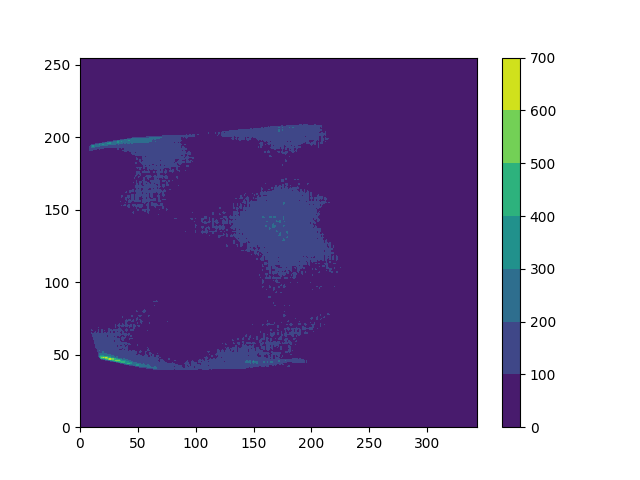

In [15]:
raw_image_name=os.path.join(avgimagepath,rawimagelist[0]) 
with open(raw_image_name) as file:
    tsv_data = np.loadtxt(file, delimiter='\t')
plt.figure()
h = plt.contourf(tsv_data)
plt.colorbar()
print("The shape of the raw data is: ",tsv_data.shape)
#plt.xlim(120,150)
#plt.ylim(150,200)


In [16]:
#load the module and import functions for reading the parameter table from the calib2d file
from importlib import reload
import specsanalyzer.convert
reload(specsanalyzer.convert)   
#let's get all the functions to be tested
from specsanalyzer.convert import get_damatrix_fromcalib2d
from specsanalyzer.convert import get_rr_da


In [17]:
#GET THE CALIBRATION FILE NAME FROM THE EXAMPLE FOLDER
calib2dfilename=os.path.realpath(os.path.join(workingdir, '..','tests\data\dataEPFL\phoibosEPFL.calib2d'))
#GET THE INFO FILE NAME FROM THE EXAMPLE FOLDER, SCAN 9159
#navigate to example data
exampledatapath=os.path.realpath(os.path.join(workingdir, '..','tests\data\dataEPFL\\2020\\02 February\Day 17\Raw Data\9159'))
filelist=os.listdir(exampledatapath)
str_match = list(filter(lambda x: 'info.txt' in x, filelist))
infofilename=os.path.join(exampledatapath,str_match[0]) 

damatrix=get_damatrix_fromcalib2d(infofilename,calib2dfilename)
scanparameters=get_scanparameters(infofilename,calib2dfilename)
# now the calibration matrix contains the ainner in line1 , and the three 
# Da parameters, depending on the mode, some Das might be zero

NameError: name 'workingdir' is not defined

In [ ]:
scanparameters

In [ ]:
reload(specsanalyzer.convert)    
from specsanalyzer.convert import calculate_polynomial_coef_da

#we now have to convert the polynomial coeffiecients from the Da matrix
dapolymatrix=calculate_polynomial_coef_da(scanparameters)
scanparameters

In [ ]:
reload(specsanalyzer.convert)
from specsanalyzer.convert import mcp_position_mm

In [ ]:
# For the example scan we have the following settings:
ek=float(scanparameters["KineticEnergy"])
ep=float(scanparameters["PassEnergy"])
erange=scanparameters["eRange"]
arange=scanparameters["aRange"]
angles=np.linspace(-20,20,1024)
energies=np.linspace(ek+ep*erange[0],ek+ep*erange[1],2048)
ainner=15
energymesh,anglemesh=np.meshgrid(energies,angles)

testimage=mcp_position_mm(energymesh,anglemesh,scanparameters)

In [ ]:
from matplotlib import cm

colorlevels=np.linspace(-15,15,50)

plt.contourf(energies,angles,testimage,cmap=cm.bwr,levels=colorlevels)
#plt.xlim(10,20)
plt.ylim(-18,18)
#plt.clim(0,5)
plt.colorbar()

#not sure if this is correct.. but better than before

In [ ]:
reload(specsanalyzer.convert)
from specsanalyzer.convert import calculate_matrix_correction 
from specsanalyzer.convert import physical_unit_data

In [ ]:
# For the example scan we have the following settings:
(ek_axis, angle_axis, angular_correction_matrix, e_correction,
         jacobian_determinant)=calculate_matrix_correction(scanparameters)

In [ ]:
from matplotlib import cm

plt.contourf(ek_axis,angle_axis,angular_correction_matrix)
plt.colorbar()

In [ ]:
plt.contourf(ek_axis,angle_axis,jacobian_determinant)
plt.colorbar()

In [ ]:
plt.plot(e_correction)

In [ ]:
corrected_data=physical_unit_data(raw_data,
                       angular_correction_matrix,
                       e_correction,
                       jacobian_determinant)

In [ ]:
h = plt.contourf(raw_data)
plt.colorbar()

In [ ]:
print(ek_axis.shape)
print(angle_axis.shape)
print(corrected_data.shape)
colorlevels=np.linspace(0,130000,100)
h = plt.contourf(ek_axis,angle_axis,corrected_data,levels=colorlevels)
plt.colorbar()
#plt.xlim(34,37)
#plt.ylim(-15,15)

In [ ]:
h = plt.contourf(angle_axis,ek_axis,corrected_data.transpose(),levels=colorlevels)
plt.colorbar()

In [9]:
from specsanalyzer import SpecsAnalyzer
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
spa = SpecsAnalyzer()



config_dictionary=specsanalyzer.io.parse_calib2d_to_dict('../tests/data/dataEPFL/phoibosEPFL.calib2d')
config_file=specsanalyzer.settings.parse_config(config_dictionary)

In [3]:
#get the das  and the rr vector 
rr_array, da_matrix=  specsanalyzer.convert.get_rr_da("WideAngleMode", config_file)


KeyError: 'calib2d_dict'

In [ ]:
colorlevels=np.linspace(0,130000,100)
h = plt.contourf(ek_axis,angle_axis,corrected_data,levels=colorlevels)
plt.colorbar()
#plt.xlim(34,37)
#plt.ylim(-15,15)

In [1]:
from specsanalyzer import SpecsAnalyzer
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
spa = SpecsAnalyzer()
a=spa.test()
type(a)

c:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


dict

In [2]:
a

{'calib2d_file': './config/phoibos150.calib2d',
 'nx_pixel': 1376,
 'ny_pixel': 1024,
 'pixel_size': 0.00645,
 'binning': 4,
 'magnification': 4.54,
 'Ang_Offset_px': 0,
 'E_Offset_px': 0,
 'apply_fft_filter': False,
 'calib2d_dict': {'aUnit': 'unit',
  'aInner': 10.0,
  'eShift': [-0.05, 0.0, 0.05],
  'eRange': [-0.066, 0.066],
  'aRange': [-15.0, 15.0],
  'eGrid': 0.01,
  'aGrid': 1.0,
  'De1': 0.0033,
  'Da1': [1.0, 1.0, 1.0],
  'Da3': [0.0, 0.0, 0.0],
  'Da5': [0.0, 0.0, 0.0],
  'Da7': [0.0, 0.0, 0.0],
  'LowAngularDispersion': {'rr': {0.07: {'aInner': 7.0,
     'Da1': [1.003, 1.356, 1.334],
     'Da3': [-0.02919, 0.04922, 0.2014],
     'Da5': [-0.0805, 0.0122, 0.06046],
     'Da7': [0.05888, -0.02795, -0.0782]},
    0.1: {'aInner': 7.0,
     'Da1': [1.059, 1.33, 1.409],
     'Da3': [-0.02261, 0.05624, 0.1846],
     'Da5': [-0.02439, 0.009775, 0.06243],
     'Da7': [0.008029, -0.02778, -0.08614]},
    0.15: {'aInner': 7.0,
     'Da1': [1.066, 1.313, 1.457],
     'Da3': [-0.02208, 0

int

In [27]:
print(a)

33
